In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import EMNIST
# import torch.optim as optim
# from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
# from PIL import Image, ImageOps
import numpy as np
import cv2

/usr/lib/python3.12/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [2]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=1.0),  # Flip the image horizontally with 100% probability
    transforms.RandomRotation((90, 90)),  # Rotate 90 degrees anti-clockwise
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [3]:
# classes = EMNIST(root='data/', split='balanced', train=True, download=True, transform=transform).classes

classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'd', 'e', 'f', 'g', 'h', 'n', 'q', 'r', 't']

In [4]:
# Define a simple CNN architecture
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 47)  # 47 classes in the 'byclass' split

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [26]:
model = SimpleCNN()

# Train the model
# train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=5)

# Move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model.to(device)

# Run code from here to use pretrained weights
model.load_state_dict(torch.load("./model4_weights.pth", weights_only=True, map_location=device))

cpu


<All keys matched successfully>

In [6]:
# Function to preprocess the image
def preprocess_image(img, invert=False, resize=True, show_output=True):
    if invert:
        # Invert the colors
        img = np.bitwise_not(img)

        if show_output:
            # Display the original grayscale image
            plt.figure()
            plt.title("Inverted Grayscale Image")
            plt.imshow(img, cmap='gray')
            plt.axis('off')
            plt.show()

    if resize:
        # Resize the image to 28x28
        img = cv2.resize(img, (28, 28), interpolation=cv2.INTER_CUBIC)

        if show_output:
            # Display the resized image
            plt.figure()
            plt.title("Resized Image (28x28)")
            plt.imshow(img, cmap='gray')
            plt.axis('off')
            plt.show()

    # Define the transformations: convert to tensor and normalize
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    # Apply the transformations
    img_tensor = transform(img)

    # Add batch dimension (1, 1, 28, 28)
    img_tensor = img_tensor.unsqueeze(0)

    return img, img_tensor

In [7]:
model.eval()  # Set the model to evaluation mode

SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=47, bias=True)
)

In [8]:
# Function to predict the label of the processed image
def predict_image(model, image_tensor):
    with torch.no_grad():
        outputs = model(image_tensor.to(device))
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs.data, 1)
        return predicted.item(), probabilities.squeeze().cpu().numpy()

In [9]:
def get_top_n_classes(model, img_tensor, n=5, prob_threshold=0.00):
    """
    Returns the top n classes and their probabilities for a given image tensor using the provided model
    Filters the model output based on the probability threshold, returns n best options (if they exist)
        Parameters:
            - model: The model used for prediction.
            - img_tensor: The image tensor to be predicted.
            - n (optional): The number of top classes to return. Default is 5.
            - prob_threshold (optional): The probability threshold for considering a class. Default is 0.001.
        Returns:
            - sorted_classes: A list of the top n classes.
            - sorted_probs: A list of the corresponding probabilities for the top n classes.
    """

    global classes
    _, probs = predict_image(model, img_tensor)

    # Define the mapping from lowercase to uppercase
    lower_to_upper = {
        'a': 'A', 'b': 'B', 'd': 'D', 'e': 'E', 'f': 'F',
        'g': 'G', 'h': 'H', 'n': 'N', 'q': 'Q', 'r': 'R', 't': 'T'
    }

    # Initialize the new_classes and new_probs dictionaries
    new_classes = list('0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ')
    new_probs = {cls: 0.0 for cls in new_classes}

    # Merge the probabilities for lowercase and uppercase letters
    for cls, prob in zip(classes, probs):
        if cls in lower_to_upper:
            new_probs[lower_to_upper[cls]] += prob
        else:
            new_probs[cls] += prob

    # Sort the merged probabilities
    sorted_vals = sorted(new_probs.items(), key=lambda x: x[1], reverse=True)

    # Filter based on probability threshold and get the top n classes
    filtered_vals = [val for val in sorted_vals if val[1] >= prob_threshold][:n]

    if not filtered_vals:
        return None

    sorted_classes = [val[0] for val in filtered_vals]
    sorted_probs = [val[1] for val in filtered_vals]

    return sorted_classes, sorted_probs

## Helper classes

In [10]:
class output_char():
    """
        Represents an output character with its associated information.

    Attributes:
        - character: The image of the character stored as a numpy array.
        - predicted_chars: The top predicted characters.
        - predicted_probs: The respective probabilities of the predicted characters.
        - corr: The coordinates of the character in the original image.
        - shape: The shape of the character image.
    """
    def __init__(self, char_img, probs, classes, col_corr, row_corr, width, height):
        self.character = char_img
        self.predicted_chars = classes
        self.predicted_probs = probs
        self.corr = (row_corr, col_corr)
        self.shape = (height, width)


    def __str__(self):
        return \
            f"Character's coordinates in original image: {self.corr}\n" \
            f"Top predicted characters : {self.predicted_chars}\n" \
            f"Respective probabilities : {self.predicted_probs}\n" \
            f"Shape of image : {self.shape}\n"

In [11]:
def get_output_char(model, img_tensor, img_numpy, col, row, width, height):
    """
        Returns the an object of output_char class containing the predicted character,
        it's corrdinates, shape and the top predicted characters and their probabilities.
    Parameters:
        model (object): The model used for prediction.
        img_tensor (object): The image tensor.
        img_numpy (object): The image numpy array.
        col (int): The col corrdinate of the character in the original image.
        row (int): The row corrdinate of the character in the original image.
        width (int): The width of cropped character ( img_numpy ).
        height (int): The height of cropped character ( img_numpy ).
    Returns:
        None or object of output_char
    """

    prediction = get_top_n_classes(model, img_tensor)
    if prediction is None:
        return None

    classes, probs = prediction

    return output_char(img_numpy, probs, classes, col_corr=col, row_corr=row, width=width, height=height)

In [13]:
class line_chars():
    """
        A class representing a line of characters ( objects of output_char class ).
    Attributes:
        - starty:   The starting y-coordinate of the line.
        - endy:     The ending y-coordinate of the line.
        - chars:    A list of characters (objects of output_char) in the line.
    Methods:
        - __init__(self, y1, y2, char): Initializes a line_chars object with the given y-coordinates and character (object of output_char).
        - can_be_added(self, y1, y2): Checks if a character with given y-coordinates can be added to the line or should be added to some other line instead.
        - add_char(self, y1, y2, char): Adds a character to can_be_added() is True.
        - sort_characters(self): Sorts the characters in the line based on their starting x-corrdinates value.
    """
    def __init__(self, y1, y2, char):
        self.starty = y1
        self.endy = y2
        self.chars = [char]


    def can_be_added(self, y1, y2):
        return (y1 >= self.starty and y1 <= self.endy) or (y2 >= self.starty and y2 <= self.endy)


    def add_char(self, y1, y2, char):
        if not self.can_be_added(y1, y2):
            return

        self.chars.append(char)
        # TODO: Don't update the lines' y-coordinates and just rely on the initial values
        #       provided by the line segmentation code
        self.starty = min(self.starty, y1)
        self.endy = max(self.endy, y2)


    def sort_characters(self):
        self.chars = sorted(self.chars, key=lambda x: x.corr[1])

In [14]:
def append_to_correct_line(lines_list, row, h, char):
    """
        Appends a character to the correct line in a list of line_chars objects.
    Parameters:
        - lines_list (list): A list of line_chars objects.
        - row (int): The starting y-offset of the character on the image (row number).
        - h (int): The height of the character.
        - char (object of output_char): The character to be added.
    Returns:
    None
    """
    lines_count = len(lines_list)
    line_added = False

    for line_num in range(lines_count):
        if lines_list[line_num].can_be_added(row, row + h):
            lines_list[line_num].add_char(row, row + h, char)
            line_added = True
            break
    if not line_added:
        lines_list.append(line_chars(row, row + h, char))

In [15]:
class word():
    def __init__(self, char):
        """
            Initializes a word object with an object of output_char class.
        Parameters:
            - char: An output_char object representing the first character of the word.
        """
        self.startx = char.corr[1]
        self.endx = char.corr[1], char.shape[1]
        self.characters = [char]


    def can_add_char(self, char, word_spacing_thresh):
        """
            Checks if a character can be added to the word based on the corrdinates of the given character
            & the last character of the current word.
        Parameters:
            - char: The output_char object to be added.
            - word_spacing_thresh: The maximum allowed spacing between characters.
        Returns:
            - True if the character can be added, False otherwise.
        """
        last_char_end = self.characters[-1].corr[1] + self.characters[-1].shape[1]

        # We can add the provided character if it starts after the current character and is within the word_spacing_thresh
        return char.corr[1] <= last_char_end + word_spacing_thresh #and char.corr[1] >= last_char_end


    def add_char(self, char, word_spacing_thresh, verify=True):
        """
            Adds a character to the word if can_add_char is True or verification is forced to be off.
        Parameters:
            - char: The output_char object to be added.
            - word_spacing_thresh: The maximum allowed spacing between characters to consider it the same word.
            - verify: A boolean indicating whether to verify if the character can be added or forcefully add it.
        """
        if verify and not self.can_add_char(char, word_spacing_thresh):
            return

        self.characters.append(char)
        self.endx = char.corr[1] + char.shape[1]


    def __str__(self):
        """
        Returns:
            - A string representing the word.
        """
        return ''.join([x.predicted_chars[0] for x in self.characters])

In [16]:
def process_image(img_path, ksize=3, t1=21, t2=5):
    """
        Process the provided image using opencv2 to
        remove shadows & put more emphasis on the text.
    Params:
        img_path:       str         : Path of the image to process on disk

    Returns:
        None
    """
    image = cv2.imread(img_path)
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur
    blurred = cv2.GaussianBlur(gray, (ksize, ksize), 0)

    # Apply adaptive thresholding
    thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                    cv2.THRESH_BINARY, t1, t2)

    # Apply morphological operations
    kernel = np.ones((2, 2), np.uint8)
    morph = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

    return morph

## Helper functions for extracting words out of lines

In [17]:
def get_sorted_contours(img, area_threshold=50):
    """
        Extract the contours from the provided image and sort them based on their (x,y).
    Args:
        img (numpy.array): Output of cv2.imread() function. The image to get the contours from.
        area_threshold (int, optional): Minimum area that a contour should have to be considered valid. Defaults to 50.
    """
    def get_contour_1D_pos(bbox, img_width):
        """
        Convert the provided coordinates to a 1D position similar to converting the indexes of a 2D matrix into 1D.
        """
        x, y, _, _ = bbox
        return y * img_width + x

    _, img_w = img.shape
    contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    filtered_contours = [contour for contour in contours if cv2.contourArea(contour) >= area_threshold]
    sorted_contours = sorted(filtered_contours, key=lambda x: get_contour_1D_pos(cv2.boundingRect(x), img_w))

    return sorted_contours

In [18]:
def get_curr_contour(img, contour, padding=2):
    """
        Extracts the current contour from an image and returns it as a square image.
    Parameters:
        - img: The input image.
        - contour: The contour to extract.
        - padding: The padding to add around the contour (default: 2 pixels).
    Returns:
        - curr_contour: The extracted contour as a square image ( numpy array ).
    """
    # Implementation details...
    pass

    col, row, w, h = cv2.boundingRect(contour)

    dim = max(w, h) + padding
    # Extra rows/cols to add to each side to make the image square
    extra_row = (dim - h) // 2
    extra_col = (dim - w) // 2

    # starting dimensions of the square box
    box_row_st, box_col_st = max(row - extra_row, 0), max(col - extra_col, 0)
    curr_contour = img[box_row_st:box_row_st+ dim, box_col_st:box_col_st + dim].copy()
    contour_h, contour_w = curr_contour.shape

    # Fill the contour with 0s outside the actual location of the contour
    for idx in range(contour_h):
        for j in range(contour_w):
            if cv2.pointPolygonTest(contour, (box_col_st + j, box_row_st + idx), False) < 0:
                curr_contour[idx][j] = 0

    return curr_contour

In [19]:
def get_characters_in_lines(img):
    """
        Extracts the characters from an image, predict what characters they are using model
        and group the results into lines ( objects of line_chars ).
    Args:
        img (numpy.ndarray): The input image.
    Returns:
        list: A list of objects of line_chars
    """

    lines_list = []

    temp_img = np.zeros(img.shape)

    sorted_contours = get_sorted_contours(img)

    for i in range(len(sorted_contours)):
        col, row, w, h = cv2.boundingRect(sorted_contours[i])
        curr_contour = get_curr_contour(img, sorted_contours[i])

        # Process curr_contour with model and overlay at row, col
        _, img_tensor = preprocess_image(curr_contour, show_output=False)

        prediction = get_output_char(model, img_tensor, curr_contour, col, row, w, h)
        if prediction is None:
            continue

        append_to_correct_line(lines_list, row, h, prediction)

        cv2.putText(temp_img, prediction.predicted_chars[0], (col, row), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    plt.imshow(temp_img, cmap='gray')
    plt.show()

    return lines_list

In [20]:
def get_words_list(lines_of_chars):
    """
        Group characters in objects of line_chars into a list of objects of word class.
    Args:
        lines_of_chars (list): A list of line_chars objects.
    Returns:
        list: A 2D list of words, where word[i] = List of object of word representing words in line i.
    """
    word_list = []
    for line_num, line_of_characters in enumerate(lines_of_chars):
        line_of_characters.sort_characters()

        mean_char_width = np.mean([char.shape[1] for char in line_of_characters.chars])
        word_spacing_thresh = mean_char_width

        # New line
        word_list.append([])
        words_in_current_line = 0

        for character in line_of_characters.chars:
            if words_in_current_line > 0 and word_list[line_num][-1].can_add_char(character, word_spacing_thresh):
                word_list[line_num][-1].add_char(character, word_spacing_thresh, verify=False)
            else:
                word_list[line_num].append(word(character))
                words_in_current_line += 1

    return word_list

In [21]:
def get_words_list_from_image(img_name, show_image=False):
    """
        Extracts a 2D list of words, where word[i] = List of object of word representing words in line i.
    Parameters:
        - img_name (str): The name of the image file.
        - show_image (bool): Whether to display the processed / binarized image.
    Returns:
    - words_list (list of list of objects of word): A list of words extracted from the image.
    """
    processed_img = process_image(img_name)
    inverted = np.bitwise_not(processed_img)

    if show_image:
        plt.figure()
        plt.title("Processed Image")
        plt.imshow(inverted, cmap='gray')
        plt.axis('off')
        plt.show()

    lines = get_characters_in_lines(inverted)

    return get_words_list(lines)

In [22]:
def print_words_list(words_list):
    """
        Provided a 2D list of word objects, prints the words Line by Line.

    Args:
        words_list (List of List[word]): The return value of get_words_list_from_image or get_words_list.
    """
    for line in words_list:
        for word in line:
            print(word, end=' ')
        print()

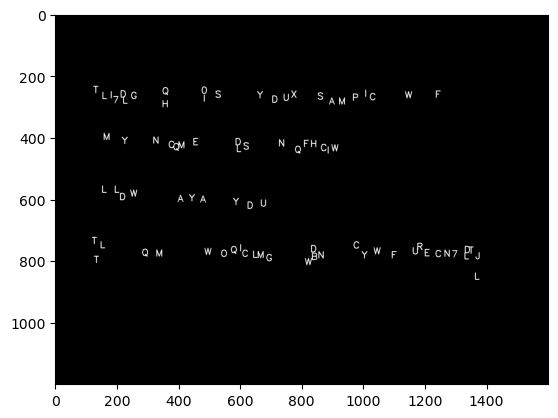

L 
TLI7DLG HQ 0I S YDUX SAMPIC WF 
MY NCQME DLS NQFHCIW 
LLDW AYA YDU 
TTL QM WOQICLMG WDBN CYWFURECN7LDTLJ 


In [27]:
img_name = './sample2.jpeg'

words_list = get_words_list_from_image(img_name)
print_words_list(words_list)


using vocabulary

In [47]:
# Sample word
sample_word = words_list[1][5]  # word location

In [48]:
import nltk
from nltk.corpus import words
from itertools import product
import numpy as np

# Download the nltk words corpus
nltk.download('words')
vocabulary = set(words.words())

# Function to extract top predictions and probabilities
def get_top_predictions_matrix(word, n=5):
    top_predictions = [char.predicted_chars[:n] for char in word.characters]
    top_probabilities = [char.predicted_probs[:n] for char in word.characters]

    max_length = max(len(preds) for preds in top_predictions)

    for preds in top_predictions:
        while len(preds) < max_length:
            preds.append('')

    for probs in top_probabilities:
        while len(probs) < max_length:
            probs.append(0.0)

    top_predictions_matrix = np.array(top_predictions)
    top_probabilities_matrix = np.array(top_probabilities)

    return top_predictions_matrix, top_probabilities_matrix

# Function to correct a word using the nltk vocabulary
def correct_word_using_vocabulary(top_predictions_matrix, top_probabilities_matrix, vocabulary):
    best_word = None
    best_prob = 0

    candidates = product(*top_predictions_matrix)

    for candidate in candidates:
        candidate_word = ''.join(candidate).lower()
        if candidate_word in vocabulary:
            combined_prob = np.prod([top_probabilities_matrix[i][top_predictions_matrix[i].tolist().index(candidate[i])] for i in range(len(candidate))])
            if combined_prob > best_prob:
                best_word = candidate_word
                best_prob = combined_prob

    return best_word, best_prob

[nltk_data] Downloading package words to /home/yilliee/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [49]:
# Get the top predictions and their probabilities
top_predictions_matrix, top_probabilities_matrix = get_top_predictions_matrix(sample_word, n=5)

# Correct the word using the vocabulary
corrected_word, combined_prob = correct_word_using_vocabulary(top_predictions_matrix, top_probabilities_matrix, vocabulary)

# Display the corrected word and its combined probability
print("Top Predictions Matrix:")
print(top_predictions_matrix)
print("\nTop Probabilities Matrix:")
print(top_probabilities_matrix)
print(f"\nPredicted Word: {sample_word}")
print(f"Corrected Word: {corrected_word}")
print(f"Combined Probability: {combined_prob}")
print("\n\n")

Top Predictions Matrix:
[['S' 'G' '5' 'F' '8']
 ['A' 'Q' 'R' 'G' 'I']
 ['M' 'W' 'N' 'H' 'A']
 ['P' 'F' '9' 'Q' 'A']
 ['I' 'F' 'L' 'T' 'J']
 ['C' 'E' 'G' 'Q' '0']]

Top Probabilities Matrix:
[[9.9999714e-01 2.5721386e-06 2.0653370e-07 2.4966923e-08 2.2372065e-08]
 [6.2109512e-01 3.7682000e-01 2.0496077e-03 3.2703250e-05 2.2703416e-06]
 [1.0000000e+00 2.0925022e-09 4.6274874e-14 9.3335805e-17 5.6804606e-18]
 [1.0000000e+00 3.0572394e-08 2.4496222e-10 2.2899974e-11 1.4466954e-11]
 [4.7541726e-01 3.1216079e-01 8.1921443e-02 7.9033360e-02 4.3462709e-02]
 [9.9925452e-01 7.3024392e-04 6.1745486e-06 5.5973442e-06 3.2385012e-06]]

Predicted Word: SAMPIC
Corrected Word: sample
Combined Probability: 3.7155437894398347e-05





all possible words

In [50]:
import nltk
from nltk.corpus import words
from itertools import product
import numpy as np

# Download the nltk words corpus
nltk.download('words')
vocabulary = set(words.words())

# Function to extract top predictions and probabilities
def get_top_predictions_matrix(word, n=5):
    top_predictions = [char.predicted_chars[:n] for char in word.characters]
    top_probabilities = [char.predicted_probs[:n] for char in word.characters]

    max_length = max(len(preds) for preds in top_predictions)

    for preds in top_predictions:
        while len(preds) < max_length:
            preds.append('')

    for probs in top_probabilities:
        while len(probs) < max_length:
            probs.append(0.0)

    top_predictions_matrix = np.array(top_predictions)
    top_probabilities_matrix = np.array(top_probabilities)

    return top_predictions_matrix, top_probabilities_matrix

# Function to correct a word using the nltk vocabulary
def correct_word_using_vocabulary(top_predictions_matrix, top_probabilities_matrix, vocabulary):
    best_word = None
    best_prob = 0
    valid_words = []

    candidates = product(*top_predictions_matrix)

    for candidate in candidates:
        candidate_word = ''.join(candidate).lower()
        if candidate_word in vocabulary:
            valid_words.append(candidate_word)
            combined_prob = np.prod([top_probabilities_matrix[i][top_predictions_matrix[i].tolist().index(candidate[i])] for i in range(len(candidate))])
            if combined_prob > best_prob:
                best_word = candidate_word
                best_prob = combined_prob

    return best_word, best_prob, valid_words

[nltk_data] Downloading package words to /home/yilliee/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [51]:
# Get the top predictions and their probabilities
top_predictions_matrix, top_probabilities_matrix = get_top_predictions_matrix(sample_word, n=5)

# Correct the word using the vocabulary and get valid words
corrected_word, combined_prob, valid_words = correct_word_using_vocabulary(top_predictions_matrix, top_probabilities_matrix, vocabulary)

# Display the results
print("Top Predictions Matrix:")
print(top_predictions_matrix)
print("\nTop Probabilities Matrix:")
print(top_probabilities_matrix)
print(f"\nCorrected Word: {corrected_word}")
print(f"Combined Probability: {combined_prob}")
print("\nValid Words in Vocabulary:")
print(valid_words)

Top Predictions Matrix:
[['S' 'G' '5' 'F' '8']
 ['A' 'Q' 'R' 'G' 'I']
 ['M' 'W' 'N' 'H' 'A']
 ['P' 'F' '9' 'Q' 'A']
 ['I' 'F' 'L' 'T' 'J']
 ['C' 'E' 'G' 'Q' '0']]

Top Probabilities Matrix:
[[9.9999714e-01 2.5721386e-06 2.0653370e-07 2.4966923e-08 2.2372065e-08]
 [6.2109512e-01 3.7682000e-01 2.0496077e-03 3.2703250e-05 2.2703416e-06]
 [1.0000000e+00 2.0925022e-09 4.6274874e-14 9.3335805e-17 5.6804606e-18]
 [1.0000000e+00 3.0572394e-08 2.4496222e-10 2.2899974e-11 1.4466954e-11]
 [4.7541726e-01 3.1216079e-01 8.1921443e-02 7.9033360e-02 4.3462709e-02]
 [9.9925452e-01 7.3024392e-04 6.1745486e-06 5.5973442e-06 3.2385012e-06]]

Corrected Word: sample
Combined Probability: 3.7155437894398347e-05

Valid Words in Vocabulary:
['sample', 'simple', 'finale']
